Aluno: Gabriel Freitas Santos
MEC 2014

0 - Desenvolvimento do Modelo AR do trabalho anterior

In [1]:
import pandas as pd
import scipy.io as sio
import numpy as np
from os import getcwd,pardir
from os.path import join ,abspath
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.tsa import ar_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

fname = join(abspath(join(getcwd(), pardir))+'\\02_feature','data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar
FeatAR = []
na=30 #Model Order
for i in tqdm(range(Nc)):
    ARmodel2 = ar_model.AutoReg(Ch2[:,i],na).fit()
    ARmodel3 = ar_model.AutoReg(Ch3[:,i],na).fit()
    ARmodel4 = ar_model.AutoReg(Ch4[:,i],na).fit()
    ARmodel5 = ar_model.AutoReg(Ch5[:,i],na).fit()
    ARparams = np.concatenate([ARmodel2.params,ARmodel3.params,ARmodel4.params,ARmodel5.params])
    FeatAR.append(ARparams)
FeatAR=np.array(FeatAR)
FeatAR.shape # X1
ln,cols = FeatAR.shape
for i in range(1,cols+1,1):
    pca = PCA(n_components=i)
    X2 = pca.fit_transform(FeatAR)
    exp_var_arr = pca.explained_variance_ratio_
    exp_var = sum(exp_var_arr)
    if exp_var>=0.9:
        break
    else:
        continue

C:\Program Files\Python38\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


  0%|          | 0/850 [00:00<?, ?it/s]

In [2]:
#Montar metodo de normalização
scaler = MinMaxScaler(feature_range=(-1,1))

indDam = y > 9 #False = "Não Danificado" | True = "Danificado"
dfARX1 = pd.concat([pd.DataFrame(scaler.fit_transform(FeatAR)),pd.DataFrame({'target':y})],axis=1) #Normalização e criação de DF para plot de X1
dfARX2 = pd.concat([pd.DataFrame(scaler.fit_transform(X2)),pd.DataFrame({'target':y})],axis=1)     #Normalização e criação de DF para plot de X2
# Separar Data set em conjuntos de treino e teste ()
train_X1, test_X1, train_X1_tg, test_X1_tg = train_test_split(dfARX1[dfARX1.columns[0:-1]], dfARX1.target, test_size=0.3, random_state=0)
train_X2, test_X2, train_X2_tg, test_X2_tg = train_test_split(dfARX2[dfARX2.columns[0:-1]], dfARX2.target, test_size=0.3, random_state=0)

1- Teste Classificador SVM

In [3]:
from sklearn import svm

#Classificador SVM para Modelo AR puro
clf_svm_X1 = svm.SVC(random_state=0).fit(train_X1,train_X1_tg)
pred_X1_svm = clf_svm_X1.predict(test_X1)

#Classificador SVM para Modelo AR aplicado PCA
clf_svm_X2 = svm.SVC(random_state=0).fit(train_X2,train_X2_tg)
pred_X2_svm = clf_svm_X2.predict(test_X2)

1.1 - Plot Matriz de Confusão com resultado

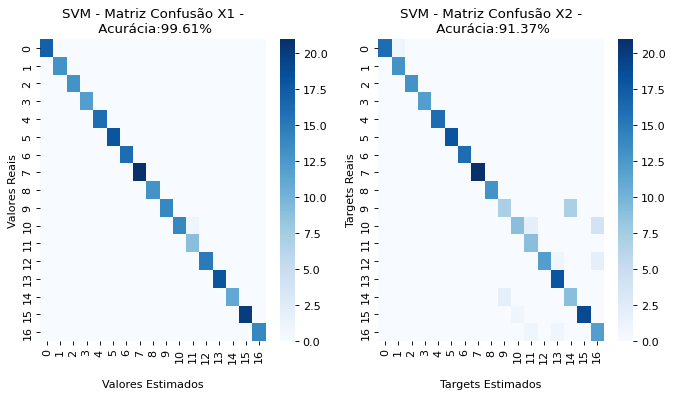

In [4]:
x1_accuracy_svm = accuracy_score(test_X1_tg, pred_X1_svm,normalize=True)
x2_accuracy_svm = accuracy_score(test_X2_tg, pred_X2_svm,normalize=True)
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
plt.subplot(121)
ax1 = sns.heatmap(confusion_matrix(test_X1_tg, pred_X1_svm),  cmap='Blues', fmt='')
ax1.set_title(f'SVM - Matriz Confusão X1 -\n Acurácia:{round(100*x1_accuracy_svm,2)}%')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')

plt.subplot(122)
ax2 = sns.heatmap(confusion_matrix(test_X2_tg, pred_X2_svm),  cmap='Blues', fmt='')
ax2.set_title(f'SVM - Matriz Confusão X2 -\n Acurácia:{round(100*x2_accuracy_svm,2)}%')
ax2.set_xlabel('\nTargets Estimados')
ax2.set_ylabel('Targets Reais')
plt.show()


1.2 - Avaliar Performance do modelo com diferentes parametros:

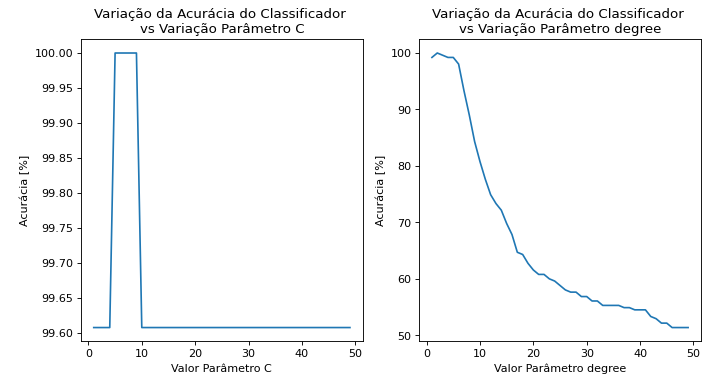

In [5]:
Crange=range(1,50,1)
x1_accuracy_svm=[]
x1_accuracy_svm_2=[]
for i,C in enumerate(Crange):
 #Classificador SVM para Modelo AR puro
    clf_svm_X1 = svm.SVC(random_state=0,C=C).fit(train_X1,train_X1_tg)
    pred_X1_svm = clf_svm_X1.predict(test_X1)
    x1_accuracy_svm.append(100*accuracy_score(test_X1_tg, pred_X1_svm,normalize=True))
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
plt.subplot(121)
ax1 = sns.lineplot(x=Crange,y=x1_accuracy_svm)
ax1.set_title(f'Variação da Acurácia do Classificador \nvs Variação Parâmetro C')
ax1.set_ylabel('\nAcurácia [%]')
ax1.set_xlabel('Valor Parâmetro C')
for i,C in enumerate(Crange):
 #Classificador SVM para Modelo AR puro
    clf_svm_X1_2 = svm.SVC(kernel='poly',degree=C).fit(train_X1,train_X1_tg)
    pred_X1_svm_2 = clf_svm_X1_2.predict(test_X1)
    x1_accuracy_svm_2.append(100*accuracy_score(test_X1_tg, pred_X1_svm_2,normalize=True))
plt.subplot(122)
ax2 = sns.lineplot(x=Crange,y=x1_accuracy_svm_2)
ax2.set_title(f'Variação da Acurácia do Classificador \nvs Variação Parâmetro degree')
ax2.set_ylabel('\nAcurácia [%]')
ax2.set_xlabel('Valor Parâmetro degree')
plt.show()

2 - Teste Classificador KNN:

In [6]:
from sklearn.neighbors import KNeighborsClassifier

#Classificador KNN para Modelo AR puro
clf_knn_x1 = KNeighborsClassifier(n_neighbors=2)
clf_knn_x1.fit(train_X1,train_X1_tg)
pred_X1_knn = clf_knn_x1.predict(test_X1)

#Classificador KNN para Modelo AR aplicado PCA
clf_knn_x2 = KNeighborsClassifier(n_neighbors=2)
clf_knn_x2.fit(train_X2,train_X2_tg)
pred_X2_knn = clf_knn_x2.predict(test_X2)

2.1 - Plot Matriz de Confusão Resultados

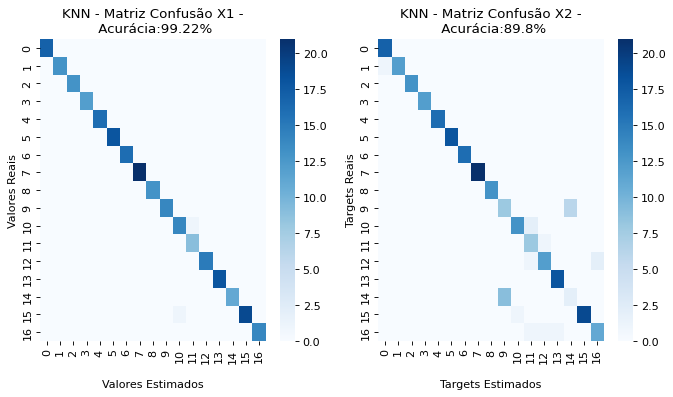

In [7]:
x1_accuracy_knn = accuracy_score(test_X1_tg, pred_X1_knn,normalize=True)
x2_accuracy_knn = accuracy_score(test_X2_tg, pred_X2_knn,normalize=True)
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
plt.subplot(121)
ax1 = sns.heatmap(confusion_matrix(test_X1_tg, pred_X1_knn),  cmap='Blues', fmt='')
ax1.set_title(f'KNN - Matriz Confusão X1 -\n Acurácia:{round(100*x1_accuracy_knn,2)}%')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')

plt.subplot(122)
ax2 = sns.heatmap(confusion_matrix(test_X2_tg, pred_X2_knn),  cmap='Blues', fmt='')
ax2.set_title(f'KNN - Matriz Confusão X2 -\n Acurácia:{round(100*x2_accuracy_knn,2)}%')
ax2.set_xlabel('\nTargets Estimados')
ax2.set_ylabel('Targets Reais')
plt.show()

2.2 - Avaliar Performance do modelo com diferentes parametros:

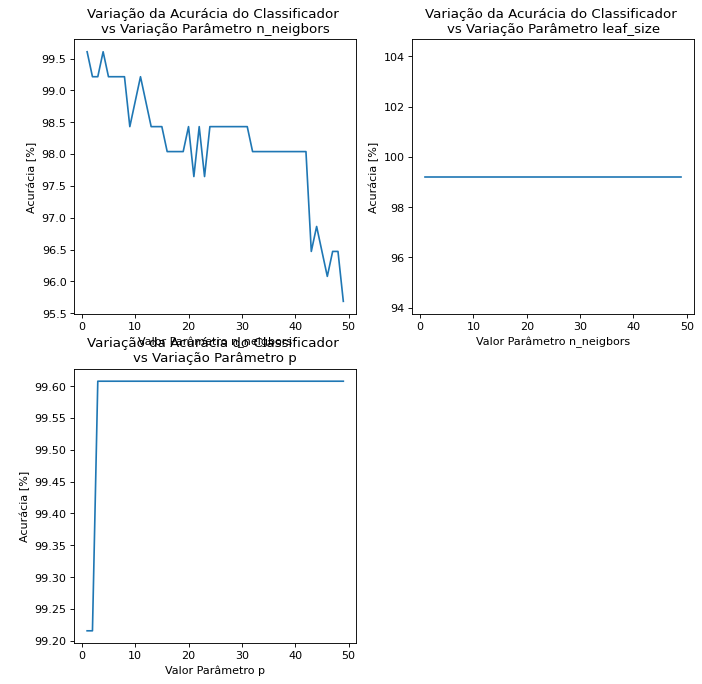

In [8]:
Crange=range(1,50,1)
x1_accuracy_knn=[]
x1_accuracy_knn_2=[]
x1_accuracy_knn_3=[]
for i,C in enumerate(Crange):
 #Classificador SVM para Modelo AR puro
    clf_knn_x1 = KNeighborsClassifier(n_neighbors=C,algorithm='kd_tree')
    clf_knn_x1.fit(train_X1,train_X1_tg)
    pred_X1_knn = clf_knn_x1.predict(test_X1)
    x1_accuracy_knn.append(100*accuracy_score(test_X1_tg, pred_X1_knn,normalize=True))
plt.figure(facecolor='white',figsize=(10, 10), dpi=80)
plt.subplot(221)
ax1 = sns.lineplot(x=Crange,y=x1_accuracy_knn)
ax1.set_title(f'Variação da Acurácia do Classificador \nvs Variação Parâmetro n_neigbors')
ax1.set_ylabel('\nAcurácia [%]')
ax1.set_xlabel('Valor Parâmetro n_neigbors')

for i,C in enumerate(Crange):
 #Classificador SVM para Modelo AR puro
    clf_knn_x1_2 = KNeighborsClassifier(n_neighbors=2,algorithm='kd_tree',leaf_size=C)
    clf_knn_x1_2.fit(train_X1,train_X1_tg)
    pred_X1_knn_2 = clf_knn_x1_2.predict(test_X1)
    x1_accuracy_knn_2.append(100*accuracy_score(test_X1_tg, pred_X1_knn_2,normalize=True))
plt.subplot(222)
ax2 = sns.lineplot(x=Crange,y=x1_accuracy_knn_2)
ax2.set_title(f'Variação da Acurácia do Classificador \nvs Variação Parâmetro leaf_size')
ax2.set_ylabel('\nAcurácia [%]')
ax2.set_xlabel('Valor Parâmetro n_neigbors')
for i,C in enumerate(Crange):
 #Classificador SVM para Modelo AR puro
    clf_knn_x1_3 = KNeighborsClassifier(n_neighbors=2,algorithm='kd_tree',p=C)
    clf_knn_x1_3.fit(train_X1,train_X1_tg)
    pred_X1_knn_3 = clf_knn_x1_3.predict(test_X1)
    x1_accuracy_knn_3.append(100*accuracy_score(test_X1_tg, pred_X1_knn_3,normalize=True))
plt.subplot(223)
ax3 = sns.lineplot(x=Crange,y=x1_accuracy_knn_3)
ax3.set_title(f'Variação da Acurácia do Classificador \nvs Variação Parâmetro p')
ax3.set_ylabel('\nAcurácia [%]')
ax3.set_xlabel('Valor Parâmetro p')
plt.show()